# Chapter  8. 금융 시계열
> 시간은 모든 일이 한꺼번에 발생하지 않도록 한다.  
-레이 커밍스  

이 장은 CSV 형식으로 된 두 가지 금융 시계열 데이터에 기반하여 진행합니다. 진행 순서는 다음과 같습니다.  
* 금융 데이터: 판다스를 사용하여 금융 시계열 데이터로 하는 기본적인 작업인 데이터 임포트, 요약 통계 도출, 시간에 따른 변동치 계산, 리샘플링 등을 다룹니다.
* 이동 통계(rolling statistics): 전체 데이터 집합에서 점점 앞으로 진행하면서 계산하는 정해진 일정 기간 동안의 통계를 말하며, 대표적인 예로 이동평균이 있습니다. 이 절에서는 판다스가 이러한 통계 계산을 어떻게 지원하는지 설명합니다.
* 상관관계 분석: S&P 500 지수와 VIX 변동성 지수라는 금융 시계열 데이터를 기반으로 하는 케이스 스터디를 다룹니다. 이 두 가지 지수가 가진 특성과 음의 상관관계를 보입니다.
* 고빈도 데이터: 금융 분야에서 흔한 고빈도 데이터인 틱(tick) 데이터를 다룹니다. 판다는 이러한 데이터를 조작하는 데도 강력합니다.

## 8.1 금융 데이터
기술적으로 CSV 파일은 각 행의 데이터가 쉼표로 구분된 텍스트 파일에 지나지 않습니다. 데이터를 임포트하기 전에 몇 가지 패키지를 임포트하고 사용자 설정을 합니다.

In [1]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

### 8.1.1 데이터 임포트
판다는 다양한 형식(CSV,SQL, 엑셀 등)으로 ㄹ저장된 데이터를 읽어 들이거나 출력할 수 있는 여러 가지 기능과 `DataFrame` 함수를 제공합니다(자세한 내용은 9장 참조).  
다음 코드는 `pd.read_csv()` 함수를 사용하여 CSV 파일에서 시계열 데이터를 임포트합니다.  
> 이 파일은 톰슨 로이터 아이콘(Thomson Reuters Eikon) 데이터 API로 읽은 여러 가지 금융 상품의 일간 데이터입니다.

In [2]:
filename = 'tr_eikon_eod_data.csv'

In [3]:
f = open(filename, 'r')
f.readlines()[:5] # 처음 다섯 행의 데이터 읽기

['Date,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD\n',
 '2010-01-01,,,,,,,,,1.4323,1096.35,,\n',
 '2010-01-04,30.57282657,30.95,20.88,133.9,173.08,113.33,1132.99,20.04,1.4411,1120.0,47.71,109.8\n',
 '2010-01-05,30.625683660000004,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.7\n',
 '2010-01-06,30.138541290000003,30.77,20.8,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.5,49.34,111.51\n']

In [4]:
f.close()

In [5]:
data = pd.read_csv(filename,
                   index_col=0, # 첫 번째 열을 인덱스로 설정
                   parse_dates=True) # 인덱스값을 날짜 및 시간으로 인식

In [6]:
data.info() # 읽은 DataFrame 객체

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


이 시점에 금융 분석가는 데이터를 조사하거나 시각화하여 살펴볼 것입니다.

In [7]:
data.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82


In [8]:
data.tail()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2018-06-25,182.17,98.39,50.71,1663.15,221.54,271.00,2717.07,17.33,1.1702,1265.00,22.01,119.89
2018-06-26,184.43,99.08,49.67,1691.09,221.58,271.60,2723.06,15.92,1.1645,1258.64,21.95,119.26
2018-06-27,184.16,97.54,48.76,1660.51,220.18,269.35,2699.63,17.91,1.1552,1251.62,21.81,118.58
2018-06-28,185.50,98.63,49.25,1701.45,223.42,270.89,2716.31,16.85,1.1567,1247.88,21.93,118.22
2018-06-29,185.11,98.61,49.71,1699.80,220.57,271.28,2718.37,16.09,1.1683,1252.25,22.31,118.65


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

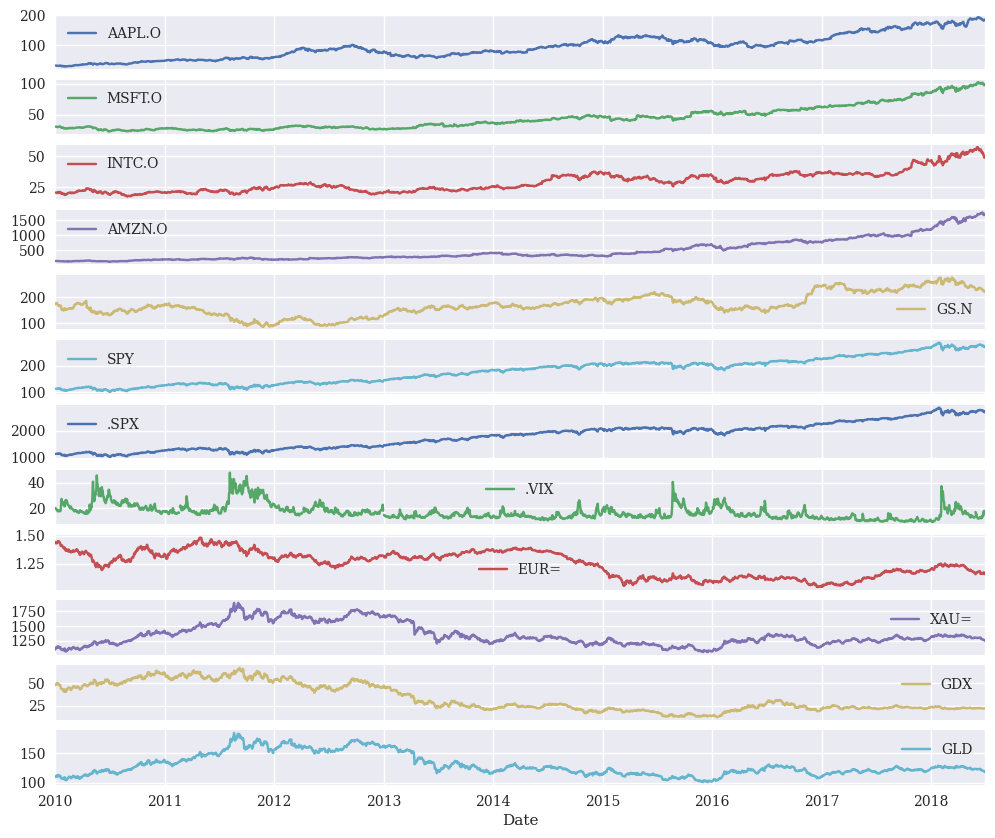

In [9]:
data.plot(figsize=(12, 10), subplots=True)

사용된 데이터는 톰슨 로이터(TR) 아이콘 데이터 API를 통해 얻었습니다. TR에서는 금융 상품을 RIC(Reuters Instrument Code)라는 심볼을 이용하여 표시합니다. 각 금융 상품의 RIC는 다음과 같습니다.

In [10]:
instruments = ['Apple Stock', 'Microsoft Stock', 'Intel Stock', 'Amazon Stock',
               'Golden Sachs Stocks', 'SPDR S&P 500 ETF Trust', 'S&P 500 Index',
               'VIX Volatility Index', 'EUR/USD Exchange Rate', 'Gold Price',
               'VanEck Vectors Gold Miners ETF', 'SPDR Gold Trust']

In [11]:
for ric, name in zip(data.columns, instruments):
    print(f'{ric:8s} | {name}')

AAPL.O   | Apple Stock
MSFT.O   | Microsoft Stock
INTC.O   | Intel Stock
AMZN.O   | Amazon Stock
GS.N     | Golden Sachs Stocks
SPY      | SPDR S&P 500 ETF Trust
.SPX     | S&P 500 Index
.VIX     | VIX Volatility Index
EUR=     | EUR/USD Exchange Rate
XAU=     | Gold Price
GDX      | VanEck Vectors Gold Miners ETF
GLD      | SPDR Gold Trust


### 8.1.2 요약 통계
금융 분석가가 취할 다음 단계는 서로 다른 요약 통계를 살펴봄으로써 전체 데이터에 대한 '감'을 얻는 것입니다.

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


In [13]:
data.describe().round(2) # 각 열의 표준 통계 데이터

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
count,2138.00,2138.00,2138.00,2138.00,2138.00,2138.00,2138.00,2138.00,2216.00,2211.00,2138.00,2138.00
mean,93.46,44.56,29.36,480.46,170.22,180.32,1802.71,17.03,1.25,1349.01,33.57,130.09
std,40.55,19.53,8.17,372.31,42.48,48.19,483.34,5.88,0.11,188.75,15.17,18.78
min,27.44,23.01,17.66,108.61,87.70,102.20,1022.58,9.14,1.04,1051.36,12.47,100.50
25%,60.29,28.57,22.51,213.60,146.61,133.99,1338.57,13.07,1.13,1221.53,22.14,117.40
50%,90.55,39.66,27.33,322.06,164.43,186.32,1863.08,15.58,1.27,1292.61,25.62,124.00
75%,117.24,54.37,34.71,698.85,192.13,210.99,2108.94,19.07,1.35,1428.24,48.34,139.00
max,193.98,102.49,57.08,1750.08,273.38,286.58,2872.87,48.00,1.48,1898.99,66.63,184.59


> **TIP** 빠르게 살펴보기  
판다스는 새로 읽은 금융 시계열 데이터의 전반적인 모습을 쉽게 살필 수 있는 `info()`나 `describe()` 등의 다양한 메서드를 제공합니다. 이러한 메서드를 사용하면 데이터를 정상적으로 읽었는지 또는 `DataFrame` 객체가 `DatetimeIndex` 자료형 인덱스를 가지는지 쉽게 확인할 수 있습니다.

물론 통계 데이터를 사용자가 맞춤 설정할 수 있는 옵션도 있습니다.

In [14]:
data.mean()

AAPL.O      93.455973
MSFT.O      44.561115
INTC.O      29.364192
AMZN.O     480.461251
GS.N       170.216221
SPY        180.323029
.SPX      1802.713106
.VIX        17.027133
EUR=         1.248587
XAU=      1349.014130
GDX         33.566525
GLD        130.086590
dtype: float64

In [15]:
data.aggregate([min, np.mean, np.std, np.median, max]).round(2)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
min,27.44,23.01,17.66,108.61,87.70,102.20,1022.58,9.14,1.04,1051.36,12.47,100.50
mean,93.46,44.56,29.36,480.46,170.22,180.32,1802.71,17.03,1.25,1349.01,33.57,130.09
std,40.55,19.53,8.17,372.31,42.48,48.19,483.34,5.88,0.11,188.75,15.17,18.78
median,90.55,39.66,27.33,322.06,164.43,186.32,1863.08,15.58,1.27,1292.61,25.62,124.00
max,193.98,102.49,57.08,1750.08,273.38,286.58,2872.87,48.00,1.48,1898.99,66.63,184.59


`aggregate` 메서드를 사용하면 사용자가 만든 함수도 쓸 수 있습니다.  
### 8.1.3 시간에 따른 변화
통계 분석 방법은 절대적인 값보다 시간에 따른 변화에 기반하는 경우가 많습니다. 값의 차이, 퍼센트 변화율, 로그 수익률과 같이 시간에 따른 변화를 계산할 수 있는 방법이 있습니다. 우선 값의 차이부터 살펴보죠.

In [16]:
data.diff().head() # diff() 메서드는 두 인덱스값 사이의 차이를 계산합니다.

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0088,23.65,NaN,NaN
2010-01-05,0.052857,0.010,-0.01,0.79,3.06,0.30,3.53,-0.69,-0.0043,-1.35,0.46,-0.10
2010-01-06,-0.487142,-0.190,-0.07,-2.44,-1.88,0.08,0.62,-0.19,0.0044,19.85,1.17,1.81
2010-01-07,-0.055714,-0.318,-0.20,-2.25,3.41,0.48,4.55,-0.10,-0.0094,-6.60,-0.24,-0.69


In [17]:
data.diff().mean()

AAPL.O    0.064737
MSFT.O    0.031246
INTC.O    0.013540
AMZN.O    0.706608
GS.N      0.028224
SPY       0.072103
.SPX      0.732659
.VIX     -0.019583
EUR=     -0.000119
XAU=      0.041887
GDX      -0.015071
GLD      -0.003455
dtype: float64

통계적 관점에서 절대적인 차이값은 시계열 데이터의 스케일에 좌우되기 때문에 최적의 선택이 아닙니다. 따라서 퍼센트 변화를 계산하는 것을 선호합니다. 다음 코드는 금융 관점에서 시계열 데이터의 퍼센트 변화율 혹은 퍼센트 수익률(단순 수익률)을 계산하여 각 열별로 평균값을 시각화합니다.

In [18]:
data.pct_change().round(3).head() # pct_change() 메서드는 두 인덱스값 사이의 퍼센트 변화율을 계산합니다.

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006,0.022,NaN,NaN
2010-01-05,0.002,0.000,-0.000,0.006,0.018,0.003,0.003,-0.034,-0.003,-0.001,0.010,-0.001
2010-01-06,-0.016,-0.006,-0.003,-0.018,-0.011,0.001,0.001,-0.010,0.003,0.018,0.024,0.016
2010-01-07,-0.002,-0.010,-0.010,-0.017,0.020,0.004,0.004,-0.005,-0.007,-0.006,-0.005,-0.006


<AxesSubplot:>

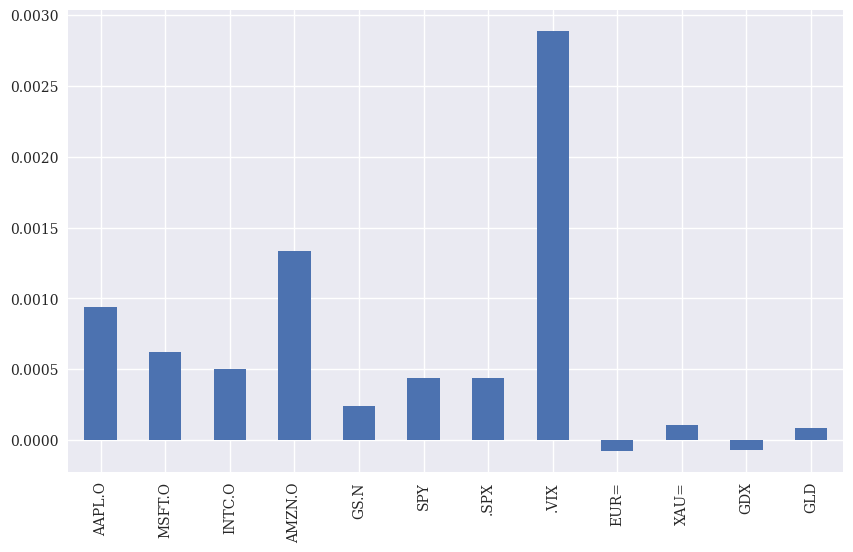

In [19]:
data.pct_change().mean().plot(kind='bar', figsize=(10, 6))

퍼센트 수익률의 대체제로 로그 수익률을 쓸 수 있습니다. 로그 수익률이 금융공학적 관점에서 더 다루기 쉽기 때문에 선호합니다.  
다음 그림은 하나의 금융 시계열에 대한 누적 로그 수익률을 보여줍니다. 이런 유형의 플롯은 보통 정규화를 합니다.

In [20]:
rets = np.log(data / data.shift(1)) # 벡터화 방법으로 로그 수익률 계산

In [21]:
rets.head().round(3) # 결과 중 일부

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006,0.021,NaN,NaN
2010-01-05,0.002,0.000,-0.000,0.006,0.018,0.003,0.003,-0.035,-0.003,-0.001,0.010,-0.001
2010-01-06,-0.016,-0.006,-0.003,-0.018,-0.011,0.001,0.001,-0.010,0.003,0.018,0.024,0.016
2010-01-07,-0.002,-0.010,-0.010,-0.017,0.019,0.004,0.004,-0.005,-0.007,-0.006,-0.005,-0.006


<AxesSubplot:xlabel='Date'>

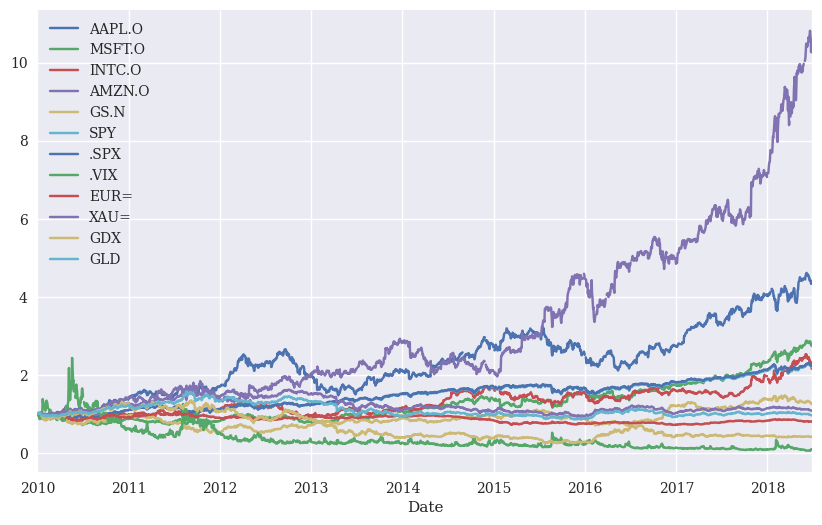

In [22]:
rets.cumsum().apply(np.exp).plot(figsize=(10, 6)) # 시간에 따른 누적 로그 수익률 표시. cumsum() 함수를 호출하고 np.exp()를 적용합니다.

### 8.1.4 리샘플링
리샘플링(resampling)은 시계열 분석에서 중요한 연산입니다. 예를 들어 다운샘플링(downsampling)은 틱 데이터를 1분 간격의 시계열로 바꾸거나 일간 데이터를 주간 혹은 월간 데이터로 바꿉니다.

In [23]:
data.resample('1w', label='right').last().head() # 일간 데이터를 주간 데이터로 리샘플링

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-10,30.282827,30.66,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37
2010-01-17,29.418542,30.86,20.80,127.14,165.21,113.64,1136.03,17.91,1.4382,1129.90,47.42,110.86
2010-01-24,28.249972,28.96,19.91,121.43,154.12,109.21,1091.76,27.31,1.4137,1092.60,43.79,107.17
2010-01-31,27.437544,28.18,19.40,125.41,148.72,107.39,1073.87,24.62,1.3862,1081.05,40.72,105.96


In [24]:
data.resample('1m', label='right').last().head() # 월간 데이터로 리샘플링

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-31,27.437544,28.1800,19.40,125.41,148.72,107.3900,1073.87,24.62,1.3862,1081.05,40.72,105.960
2010-02-28,29.231399,28.6700,20.53,118.40,156.35,110.7400,1104.49,19.50,1.3625,1116.10,43.89,109.430
2010-03-31,33.571395,29.2875,22.29,135.77,170.63,117.0000,1169.43,17.59,1.3510,1112.80,44.41,108.950
2010-04-30,37.298534,30.5350,22.84,137.10,145.20,118.8125,1186.69,22.05,1.3295,1178.25,50.51,115.360
2010-05-31,36.697106,25.8000,21.42,125.46,144.26,109.3690,1089.41,32.07,1.2305,1215.71,49.86,118.881


<AxesSubplot:xlabel='Date'>

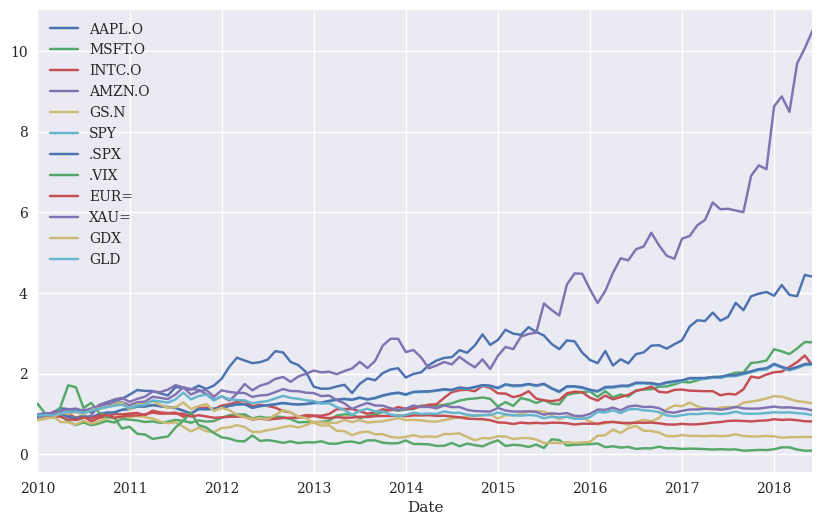

In [25]:
# 누적 로그 수익률을 플롯. 우선 cumsum() 메서드를 호출하고 np.exp 적용 후 리샘플링
rets.cumsum().apply(np.exp).resample('1m', label='right').last().plot(figsize=(10, 6))

## 8.2 이동 통계
기술적 지표라고 불리는 이동 통계를 사용하는 것은 금융 분야의 오랜 관행입니다. 이러한 이동 통계는 차티스트나 기술 투자자 등이 사용하는 기본 도구입니다. 이 절에서는 한 가지 금융 시계열만 대상으로 합니다.

In [26]:
sym = 'AAPL.O'

In [27]:
data = pd.DataFrame(data[sym].dropna())

In [28]:
data.tail()

,AAPL.O
Date,
2018-06-25,182.17
2018-06-26,184.43
2018-06-27,184.16
2018-06-28,185.50
2018-06-29,185.11


### 8.2.1 개요
판다스로 이동 통계를 계산하는 것은 쉽습니다.

In [29]:
window = 20 # 윈도우(사용할 데이터 개수) 정의

In [30]:
data['min'] = data[sym].rolling(window=window).min() # 이동 최소값 계산

In [31]:
data['mean'] = data[sym].rolling(window=window).mean() # 이동평균 계산

In [32]:
data['std'] = data[sym].rolling(window=window).std() # 이동 표준편차 계산

In [33]:
data['median'] = data[sym].rolling(window=window).median() # 이동 중앙값 계산

In [34]:
data['max'] = data[sym].rolling(window=window).max() # 이동 최대값 계산

In [35]:
data['ewma'] = data[sym].ewm(halflife=0.5,
                             min_periods=window).mean() # 반감기가 0.5인 지수가중 이동평균 계산

더 특수한 기술적 지표를 계산하려면 추가적인 패키지가 필요합니다. 사용자가 만든 지표 계산을 `apply()` 메서드로 적용할 수도 있습니다. 다음 코드는 계산된 이동 통계 중 일부를 시각화한 것입니다.

In [36]:
data.dropna().head()

,AAPL.O,min,mean,std,median,max,ewma
Date,,,,,,,
2010-02-01,27.818544,27.437544,29.580892,0.933650,29.821542,30.719969,27.805432
2010-02-02,27.979972,27.437544,29.451249,0.968048,29.711113,30.719969,27.936337
2010-02-03,28.461400,27.437544,29.343035,0.950665,29.685970,30.719969,28.330134
2010-02-04,27.435687,27.435687,29.207892,1.021129,29.547113,30.719969,27.659299
2010-02-05,27.922829,27.435687,29.099892,1.037811,29.419256,30.719969,27.856947


<AxesSubplot:xlabel='Date'>

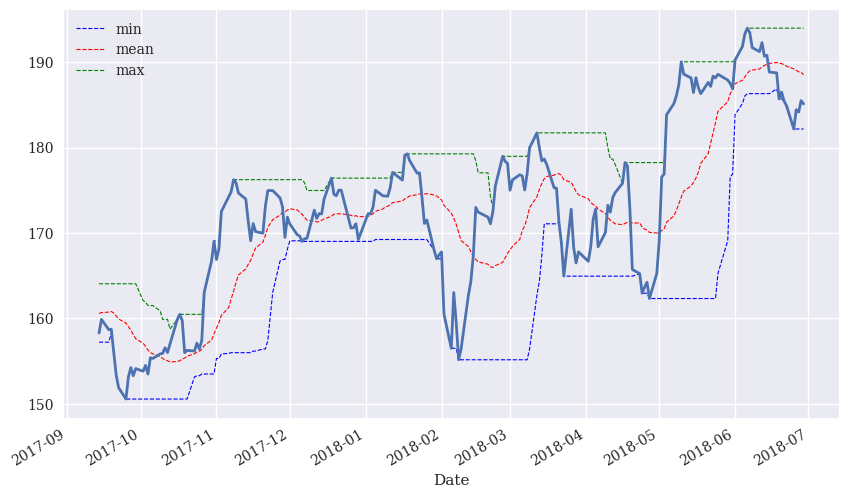

In [37]:
ax = data[['min', 'mean', 'max']].iloc[-200:].plot(
    figsize=(10, 6), style=['b--', 'r--', 'g--'], lw=0.8
) # 세 가지 이동 통계의 마지막 200개 값을 플롯
data[sym].iloc[-200:].plot(ax=ax, lw=2.0) # 원본 시계열 데이터도 플롯

### 8.2.2 기술적 분석 예제
이동 통계는 회사의 금융 리포트나 재정 상태를 분석하는 기본적 분석(fundamental analysis)과 대비되는 기술적 분석(technical analysis)의 주요 도구입니다.  
수십 년 전에 만들어진 기술적 분석 매매 방법의 하나가 이동평균 매매법입니다. 기본 아이디어는 단기 이동평균선이 장기 이동평균선보다 올라갈 때 매수를 하고 반대 경우에 매도를 하는 것입니다. 이 개념은 `DataFrame` 객체와 판다스로 정확하게 구현할 수 있습니다.  
윈도우 매개변수가 있을 때 이에 해당하는 충분한 데이터가 있어야 이동 통계를 계산할 수 있습니다. 다음 그림에서 보듯이 단순 이동평균 시계열은 충분한 데이터가 있는 날부터 보입니다.

In [38]:
data['SMA1'] = data[sym].rolling(window=42).mean() # 단기 이동평균선 계산

In [39]:
data['SMA2'] = data[sym].rolling(window=252).mean() # 장기 이동평균선 계산

In [40]:
data[[sym, 'SMA1', 'SMA2']].tail()

,AAPL.O,SMA1,SMA2
Date,,,
2018-06-25,182.17,185.606190,168.265556
2018-06-26,184.43,186.087381,168.418770
2018-06-27,184.16,186.607381,168.579206
2018-06-28,185.50,187.089286,168.736627
2018-06-29,185.11,187.470476,168.901032


<AxesSubplot:xlabel='Date'>

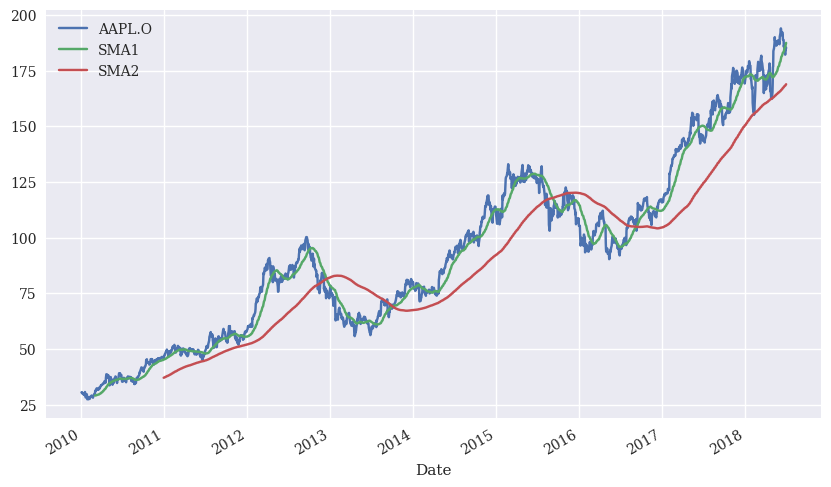

In [41]:
data[[sym, 'SMA1', 'SMA2']].plot(figsize=(10, 6)) # 두 이동평균선과 주기를 시각화

하지만 여기서 이동평균선은 목적을 위한 수단에 불과합니다. 이동평균선을 써서 매매 전략의 시점을 결정하는 것이죠. 아래 그림에서는 1이라는 값을 매수 포지션을, -1이라는 값으로 매도 포지션을 나타냈습니다. 포지션 변화는 두 이동평균선이 교차하는 지점입니다.

In [42]:
data.dropna(inplace=True) # 완벽한 데이터만 보존

In [43]:
data['positions'] = np.where(data['SMA1'] > data['SMA2'], 1, -1) # 단기 이동평균선이 더 큰 경우 1, 그 외에는 -1

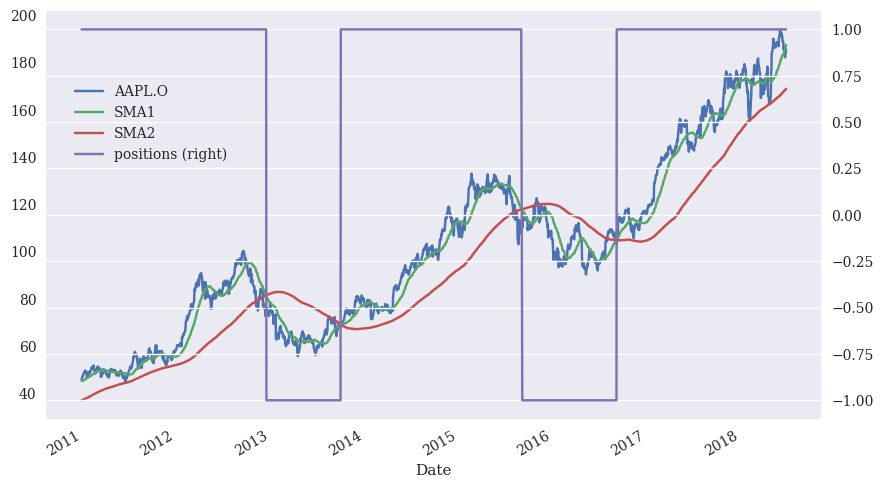

In [44]:
ax = data[[sym, 'SMA1', 'SMA2', 'positions']].plot(figsize=(10, 6),
                                                   secondary_y='positions')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

이 전략에 따르면 포지션이 변화할 때(이동 평균선이 교차할 때) 매매가 발생하는데 매수나 매도의 시작과 종료가 한꺼번에 발생하므로 총 여섯 번의 매매를 하게 됩니다.

## 8.3 상관관계 분석
판다스를 사용하여 금융 시계열 분석을 하는 또다른 예로 S&P 500 지수와 VIX 변동성 지수의 경우를 생각해봅시다. 일반적으로 S&P 500이 오르면 VIX는 떨어집니다. 이 관계는 상관관계지만 인과관계는 아닙니다. 이 절에는 S&P 500과 VIX가 강한 음의 상관관계를 가진다는 것을 어떻게 통계학적으로 보이는지 설명합니다.  

### 8.3.1 데이터
우리가 사용할 데이터는 다음 그림에 보인 두 개의 금융 시계열입니다.

In [45]:
raw = pd.read_csv('tr_eikon_eod_data.csv', index_col=0, parse_dates=True)

In [46]:
data = raw[['.SPX', '.VIX']].dropna()

In [47]:
data.tail()

,.SPX,.VIX
Date,,
2018-06-25,2717.07,17.33
2018-06-26,2723.06,15.92
2018-06-27,2699.63,17.91
2018-06-28,2716.31,16.85
2018-06-29,2718.37,16.09


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

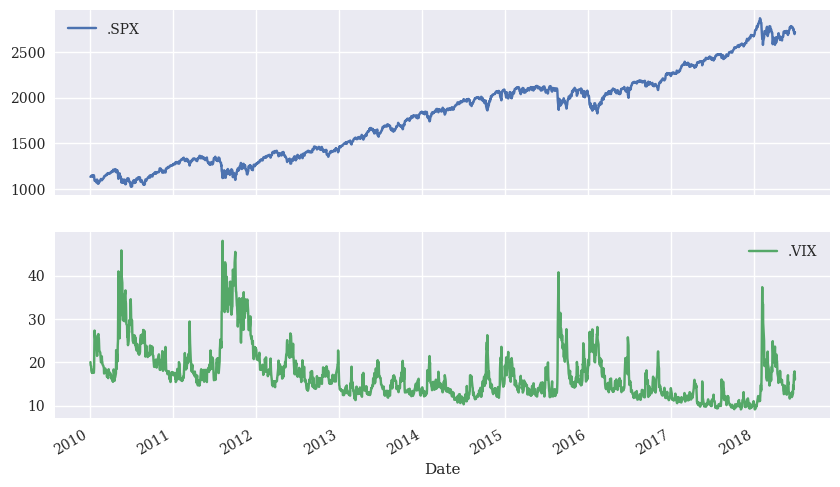

In [48]:
data.plot(subplots=True, figsize=(10, 6))

두 시계열 데이터를 하나의 플롯으로 그리면 두 지수 간의 음의 상관관계가 시각적으로 더 명확해집니다.

<AxesSubplot:xlabel='Date'>

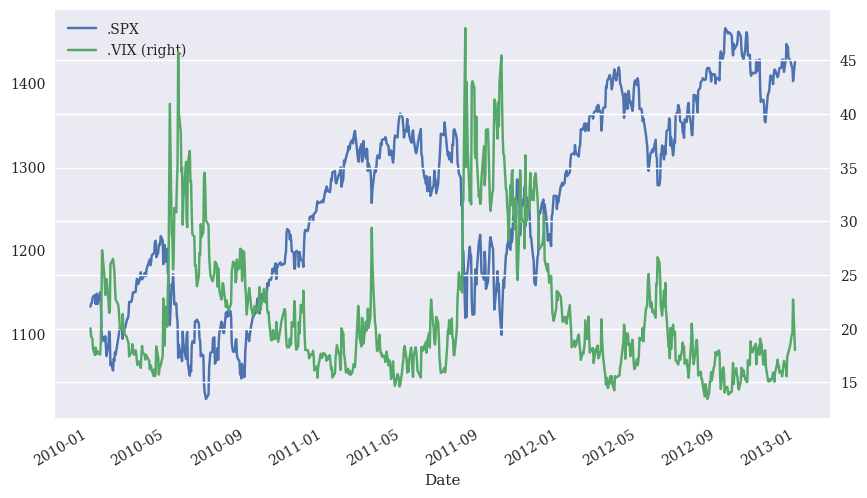

In [49]:
data.loc[:'2012-12-31'].plot(secondary_y='.VIX', figsize=(10, 6))

### 8.3.2 로그 수익률
이미 지적한 바와 같이 통계 분석은 절대적인 값이나 절대 변화량보다는 수익률을 기반으로 합니다. 따라서 더 분석을 진행하기 전에 로그 수익률을 계산합니다. 아래 그림은 로그 수익률의 시간에 따른 변화를 나타냅니다. 두 지수 모두에서 '변동성 클러스터'가 발생한다는 것을 알 수 있습니다. 일반적으로 주가지수의 변동성이 높은 시기에는 변동성 지수에도 같은 현상이 발생합니다.

In [50]:
rets = np.log(data / data.shift(1))

In [51]:
rets.head()

,.SPX,.VIX
Date,,
2010-01-04,NaN,NaN
2010-01-05,0.003111,-0.035038
2010-01-06,0.000545,-0.009868
2010-01-07,0.003993,-0.005233
2010-01-08,0.002878,-0.050024


In [52]:
rets.dropna(inplace=True)

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

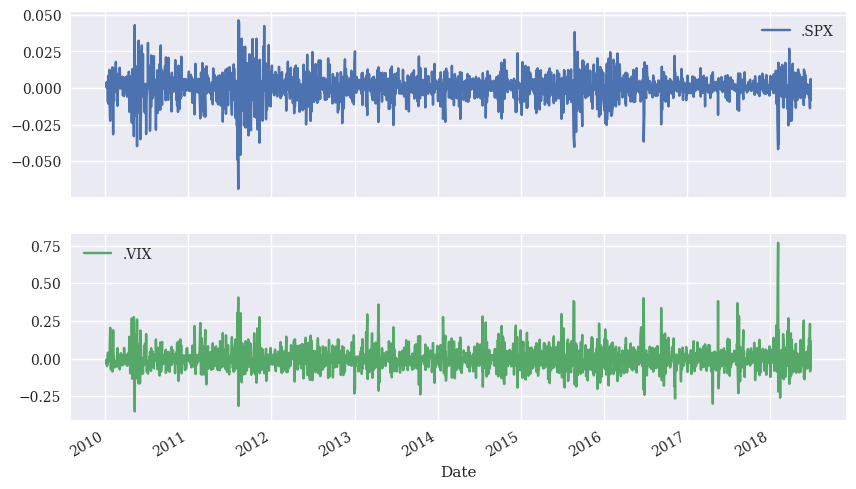

In [53]:
rets.plot(subplots=True, figsize=(10, 6))

이런 경우 판다스의 `scatter_matrix()` 플롯 함수가 시각화에 도움이 됩니다. 이 함수는 두 시계열의 로그 수익률을 그리면서 대각선에는 히스토그램이나 커널 밀도 추정치를 그릴 수 있습니다.

array([[<AxesSubplot:xlabel='.SPX', ylabel='.SPX'>,
        <AxesSubplot:xlabel='.VIX', ylabel='.SPX'>],
       [<AxesSubplot:xlabel='.SPX', ylabel='.VIX'>,
        <AxesSubplot:xlabel='.VIX', ylabel='.VIX'>]], dtype=object)

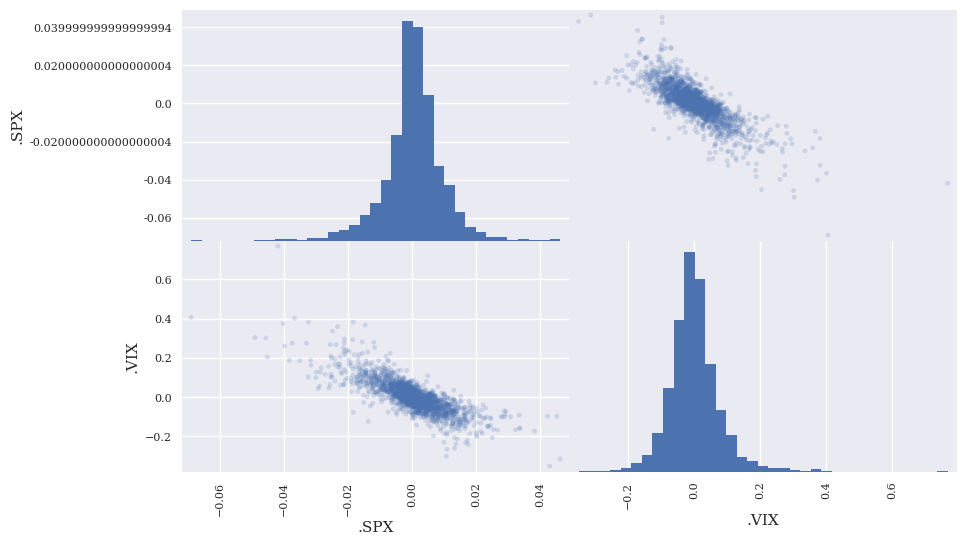

In [54]:
pd.plotting.scatter_matrix(rets, # 그릴 데이터
                           alpha=0.2, # 투명도 설정
                           diagonal='hist', # 대각선 부분에 그릴 것 (히스토그램)
                           hist_kwds={'bins':35}, # 히스토그램 함수에 넣은 키워드 인수
                           figsize=(10, 6))

### 8.3.3 최소 자승 회귀법
준비를 마치면 최소 자승(ordinary least-squares, OLS) 회귀법을 구현할 수 있습니다. 다음 그림은 로그 수익률의 스캐터플롯과 각 점의 선형회귀선을 보이고 있습니다. 선형회귀선의 기울기는 음수로, 두 지수가 음의 상관관계를 가진다는 것을 보입니다.

In [55]:
reg = np.polyfit(rets['.SPX'], rets['.VIX'], deg=1) # OLS 선형회귀 구현

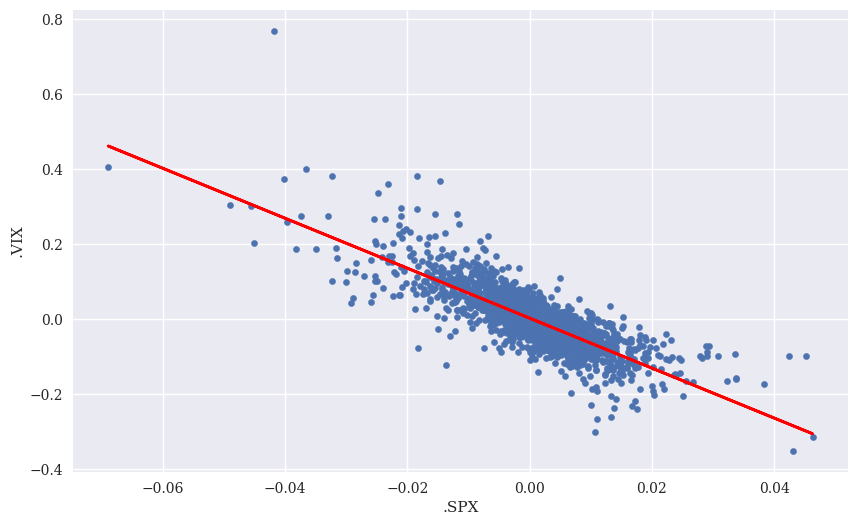

In [56]:
ax = rets.plot(kind='scatter', x='.SPX', y='.VIX', figsize=(10, 6)) # 로그 수익률의 스캐터 플롯
ax.plot(rets['.SPX'], np.polyval(reg, rets['.SPX']), 'r', lw=2) # 선형회귀선

### 8.3.4 상관관계
마지막으로 상관관계를 직접 측정합니다. 두 가지 측정 방법을 고려해보죠. 하나는 전체 데이터에 대한 상관관계고 다른 하나는 고정된 시간 동안 윈도우를 가지며 변하는 이동 상관관계입니다. 아래 그림에 두 가지 음의 상관관계를 보이고 있습니다. 이 플롯은 S&P 500 지수와 VIX 변동성 지수가 강한 음의 상관관계를 가진다는 강력한 증거입니다.

In [57]:
rets.corr() # 전체 DataFrame에 대한 상관관계 행렬

,.SPX,.VIX
.SPX,1.000000,-0.804382
.VIX,-0.804382,1.000000


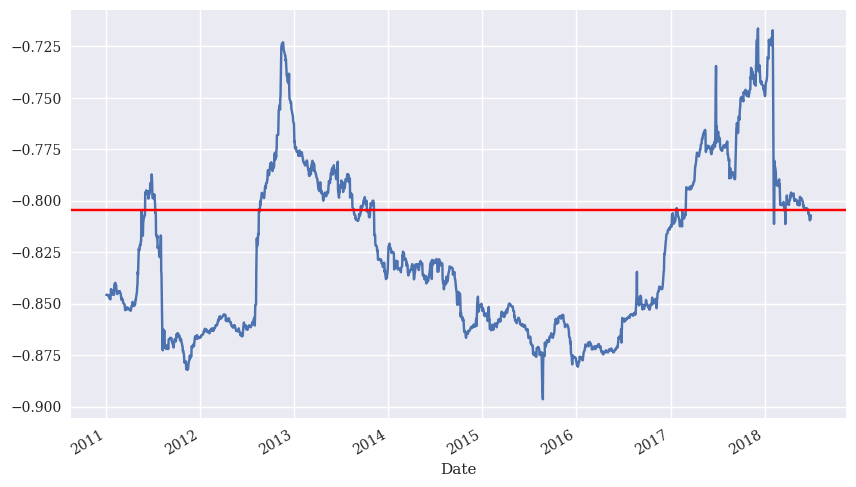

In [58]:
ax = rets['.SPX'].rolling(window=252).corr(
    rets['.VIX']
).plot(figsize=(10, 6)) # 시간에 따라 변하는 이동 상관관계 플롯
ax.axhline(rets.corr().iloc[0, 1], c='r') # 수평선으로 전체 상관관계를 표시

## 8.4 고빈도 데이터
이번 장에서는 판다스로 금융 시계열 데이터를 다룹니다. 틱 데이터는 금융 시계열 데이터의 특수한 경우입니다. 지금까지 틱 데이터도 일간 데이터와 마찬가지로 다뤄왔습니다. 판다스를 사용하면 이러한 큰 데이터를 임포트하는 것도 신속하게 할 수 있습니다. 실제로 이 데이터는 17,352개의 행으로 이루어져 있습니다.

In [59]:
%%time
# data from FXCM Forex Captial Markets Ltd.
tick = pd.read_csv('fxcm_eur_usd_tick_data.csv', index_col=0, parse_dates=True)

Wall time: 651 ms


In [60]:
tick.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 461357 entries, 2018-06-29 00:00:00.082000 to 2018-06-29 20:59:00.607000
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Bid     461357 non-null  float64
 1   Ask     461357 non-null  float64
dtypes: float64(2)
memory usage: 10.6 MB


In [61]:
tick['Mid'] = tick.mean(axis=1) # 모든 데이터 행에 대한 중간가격 계산

<AxesSubplot:>

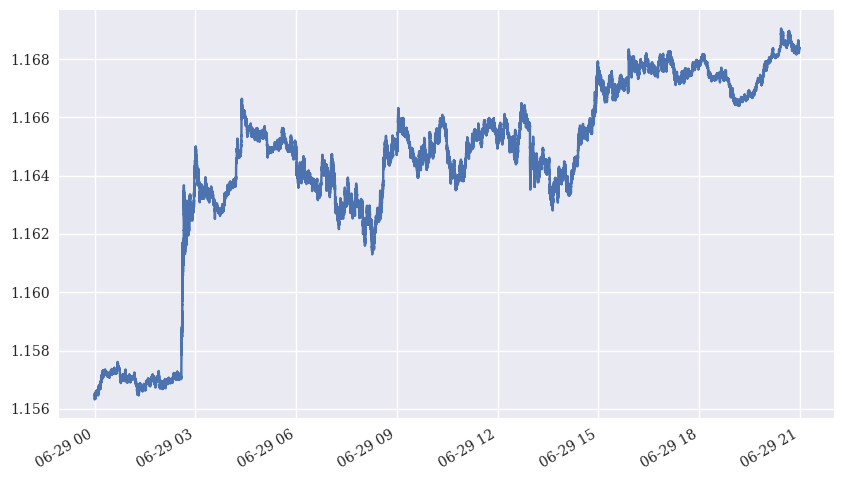

In [62]:
tick['Mid'].plot(figsize=(10, 6))

틱 데이터를 다룰 때는 시계열 데이터를 리샘플링할 필요가 있습니다. 다음 코드는 틱 데이터를 5분 간격으로 리샘플링하는 코드입니다. 이런 데이터는 기술적 분석이나 알고리즘 트레이딩 전략을 백테스팅하는 데 사용됩니다.

In [63]:
tick_resam = tick.resample(rule='5min', label='right').last()

In [64]:
tick_resam.head()

,Bid,Ask,Mid
2018-06-29 00:05:00,1.15649,1.15651,1.156500
2018-06-29 00:10:00,1.15671,1.15672,1.156715
2018-06-29 00:15:00,1.15725,1.15727,1.157260
2018-06-29 00:20:00,1.15720,1.15722,1.157210
2018-06-29 00:25:00,1.15711,1.15712,1.157115


<AxesSubplot:>

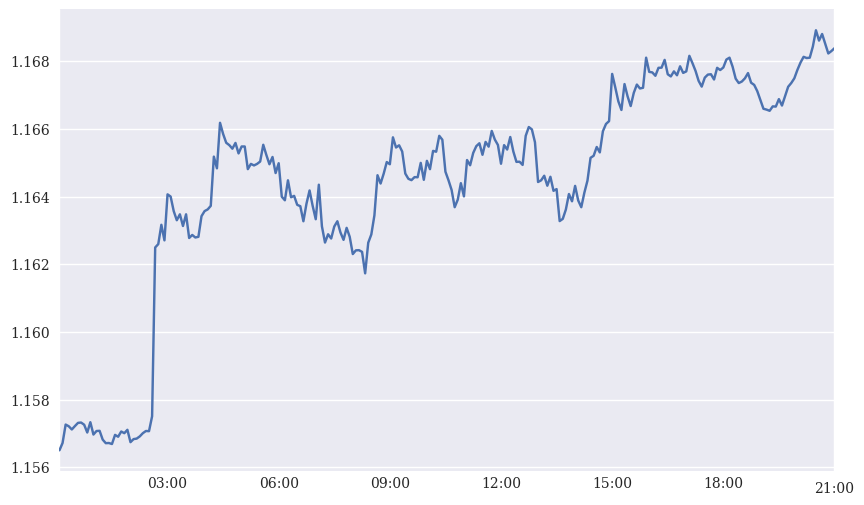

In [65]:
tick_resam['Mid'].plot(figsize=(10, 6))

## 8.5 마치며
이번 장에서는 금융 분야에서 가장 중요한 데이터 유형 중 하나인 시계열 데이터를 다루었습니다. 판다스는 이러한 데이터를 다루는 강력한 패키지입니다. 판다스를 쓰면 데이터 분석을 효율적으로 할 수 있을 뿐 아니라 시각화도 쉽습니다. 또한 다양한 데이터 소스에서 데이터를 읽어 들이거나 여러 가지 기술적 파일 형식으로 내보내는 것도 간단합니다. 이러한 입출력에 대해서는 다음 장에서 설명합니다.